In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util_io import (
    init, finalize, dump_conf, assigned_day_to_family_on_day, assigned_day_to_occupancy
)
from util_cost import (
    cal_total, n_people, family_id_choice_to_pref_cost, cal_total_preference, cal_total_accounting,
    nd_ndp1_to_account_penality
)
from util_cost import choices as family_pref
from util_check import deep_check, check_valid_all

In [138]:
# constants #
N_families = 5000
N_days = 100
N_min_people = 125
N_max_people = 300
# constants #

# params #
#path_init_conf =     '../output/m08-improved-test.csv'
path_init_conf =     '../input/another_pytorch_implementation.csv'
path_dump_improved = '../output/m14-improved.csv' # output solution

num_cpu_cores = 6
#time_limit = -1 # unlimited
time_limit = 50*60*60*1000  # in ms

occupancy_diff = 2  # +- the occupancy of input solution for each day
max_family_rank = 5  # maximum number of rank of the preference days for each family
use_hint = True      # use current input as hint
occupancy_count_as_variables = False  # use occupancy_counts as variable

In [139]:
assigned_day, family_on_day, occupancy = init(path_conf=path_init_conf)
print('Init config:')
try:
    is_valid = deep_check(assigned_day, family_on_day, occupancy)
except:
    is_valid = False
print('Valid solution: ', is_valid)
print('Total score:    ', cal_total(assigned_day, occupancy))
print('Preference cost:', cal_total_preference(assigned_day))
print('Accounting cost:', cal_total_accounting(occupancy))

Read initial configs...
Read config completed.
Init config:
deep check: everything looks fine.
Valid solution:  True
Total score:     71252.41958450396
Preference cost: 65785
Accounting cost: 5467.419584503968


In [140]:
max_accounting_cost = 7000

## Setup

In [141]:
families = range(N_families)
days = range(1, N_days + 1)

In [142]:
allowed_occupancy = range(N_min_people, N_max_people + 1)

In [143]:
# limit the occupancy choice to +- occupancy_diff of current solution
search_occupancy = {}
for day in days:
    search_occupancy[day] = range(max(occupancy[day] - occupancy_diff, N_min_people), 
                                  min(occupancy[day] + occupancy_diff, N_max_people) + 1)

In [144]:
# [Not using this for now]
# occupancy pairs [o, o_next] limited by accounting cost
viable_nd_ndp1 = nd_ndp1_to_account_penality < max_accounting_cost

(125, 300)

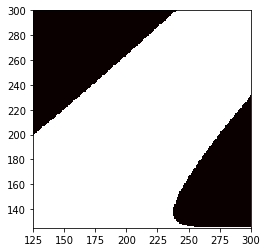

In [145]:
plt.imshow(viable_nd_ndp1, cmap='hot', interpolation='nearest')
plt.xlim(N_min_people, N_max_people)
plt.ylim(N_min_people, N_max_people)

In [146]:
# Possible choice for the family
# last choice is any day that is not on the family's preferred days
N_choices_ori = family_id_choice_to_pref_cost.shape[1]
N_choices = min(N_choices_ori, max_family_rank)
print('Limit family choice rank:', N_choices_ori, '->', N_choices)

Limit family choice rank: 11 -> 5


In [147]:
family_id_choice_to_pref_cost[:, :N_choices]

array([[  0,  50,  86, 136, 236],
       [  0,  50,  86, 136, 236],
       [  0,  50,  77, 127, 227],
       ...,
       [  0,  50, 104, 154, 254],
       [  0,  50,  95, 145, 245],
       [  0,  50,  86, 136, 236]])

## Ortools - CBC MIP solver

In [148]:
from ortools.linear_solver import pywraplp

In [149]:
solver = pywraplp.Solver('', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

In [150]:
if num_cpu_cores > 0:
    print('Set num threads:', solver.SetNumThreads(num_cpu_cores))
if time_limit > 0:
    print('Set time limit:', solver.SetTimeLimit(time_limit))

Set num threads: True
Set time limit: None


## Variables

In [151]:
# Variables
# assignment matrix[family, pref_rank]
assignment_matrix = {}
for family in families:
    for c in range(N_choices):
        assignment_matrix[family, c] = solver.BoolVar('x[%i,%i]' % (family, c))

In [152]:
len(assignment_matrix)

25000

In [153]:
possible_family_sizes = np.unique(n_people)

In [154]:
# unpreferred_day_counts[day, size]
if N_choices_ori <= N_choices:
    unpreferred_day_counts = {}
    for day in days:
        for size in possible_family_sizes:
            ub = int(N_max_people / size)
            unpreferred_day_counts[day, size] = solver.IntVar(0, ub, 'd[%i,%i]' % (day, size))
    print(len(unpreferred_day_counts))

In [155]:
# Occupancy matrix [day, N_d, N_d+1]
occupancy_matrix = {}
for day in days:
    if day < N_days:
        for o in search_occupancy[day]:
            for o_next in search_occupancy[day + 1]:
                #if viable_nd_ndp1[o, o_next]:
                occupancy_matrix[day, o, o_next] = solver.BoolVar('o[%i,%i,%i]' % (day, o, o_next))
    else:
        # last day
        for o in search_occupancy[day]:
            occupancy_matrix[day, o] = solver.BoolVar('o[%i,%i]' % (day, o))

In [156]:
len(occupancy_matrix)

2071

## Constraints

### constraint 1: each family only take one day (choice)

In [157]:
# Constraints
# constraint 1: each family only take one day (choice)
for family in families:
    solver.Add(solver.Sum([assignment_matrix[family, c]
                           for c in range(N_choices)]) == 1)

### occupancy counts

In [158]:
# constraint 2: each day can only have 125-300 people

In [159]:
N_family_pref = min(N_choices, N_choices_ori - 1)
N_family_pref

5

In [160]:
# day to dictionary of families who choose this day with value as preference rank
days_family_prefered = [{} for day in range(N_days+1)]  # day = 0 should not be used

In [161]:
for family, pref in enumerate(family_pref):
    for rank, day in enumerate(pref):
        if rank < N_family_pref:
            days_family_prefered[day][family] = rank

In [162]:
# occupancy count [intermediate variables]
occupancy_counts = {}

if occupancy_count_as_variables:
    for day in days:
        occupancy_counts[day] = solver.IntVar(
            lb=min(search_occupancy[day]), ub=max(search_occupancy[day]), name='oc[%i]' % day
        )
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        solver.Add(
            occupancy_counts[day] == (
                solver.Sum(
                    [assignment_matrix[family, pref_rank] * n_people[family] 
                     for family, pref_rank in family_prefered.items()]
                ) + (
                    solver.Sum(
                        [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                    ) if N_choices >= N_choices_ori else 0
                )
            )
        )
else:
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        occupancy_counts[day] = (
            solver.Sum(
                [assignment_matrix[family, pref_rank] * n_people[family] 
                 for family, pref_rank in family_prefered.items()]
            ) + (
                solver.Sum(
                    [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                ) if N_choices >= N_choices_ori else 0
            )
        )

In [163]:
# for day in days:
#     # find those family who like this day
#     solver.Add(occupancy_counts[day] <= N_max_people, 'ub[%i]' % day)
#     solver.Add(occupancy_counts[day] >= N_min_people, 'ub[%i]' % day)

### constraint 3: unpreferred day family count conservation for each family size

In [164]:
# constraint 3: unpreferred day family count conservation for each family size

In [165]:
family_size_to_family_ids = {
    size: np.where(n_people == size)[0] for size in possible_family_sizes
}

In [166]:
if N_choices >= N_choices_ori:
    for size in possible_family_sizes:
        solver.Add(
            solver.Sum([assignment_matrix[family, N_choices - 1]
                        for family in family_size_to_family_ids[size]])
            == solver.Sum([unpreferred_day_counts[day, size] for day in days]),
            'unpreferred_day_counts[%i]' % size
        )

### Occupancy boolean matrix normalization

In [167]:
# occupancy boolean matrix normalization
# each day only take 1 occupancy value
for day in days:
    if day < N_days:
        occupancy_normalization = solver.Sum([
            occupancy_matrix[day, o, o_next] for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
        ])
    else:
        occupancy_normalization = solver.Sum([
            occupancy_matrix[day, o] for o in search_occupancy[day]
        ])
    solver.Add(occupancy_normalization == 1)

### constrain 4: link occupancy boolean matrix to occupancy count

In [168]:
for day in days:
    if day < N_days:
        sum_from_occupancy_matrix = solver.Sum([
            occupancy_matrix[day, o, o_next] * o for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
        ])
    else:
        sum_from_occupancy_matrix = solver.Sum([
            occupancy_matrix[day, o] * o for o in search_occupancy[day]
        ])
    solver.Add(occupancy_counts[day] == sum_from_occupancy_matrix)

In [169]:
# next day occupancy consistency
if True:
    # Approach 1:
    for day in days:
        if day < N_days:
            sum_from_next_occupancy_matrix = solver.Sum([
                occupancy_matrix[day, o, o_next] * o_next for o in search_occupancy[day]
                for o_next in search_occupancy[day + 1]
            ])
            solver.Add(occupancy_counts[day + 1] == sum_from_next_occupancy_matrix)
else:
    # Approach 2:
    for day in days:
        if day + 1 < N_days:
            for o in search_occupancy[day+1]:
                solver.Add(
                    solver.Sum(
                        [occupancy_matrix[day, o_other, o] for o_other in search_occupancy[day]]
                    ) == solver.Sum(
                        [occupancy_matrix[day + 1, o, o_other] for o_other in search_occupancy[day+2]]
                    )
                )
    for o in search_occupancy[N_days]:
        solver.Add(
            solver.Sum(
                [occupancy_matrix[N_days - 1, o_other, o] for o_other in search_occupancy[N_days - 1]]
            ) == occupancy_matrix[N_days, o]
        )

## Objective

In [170]:
# Objective - Preference cost only as approximation
solver.Minimize(
    solver.Sum([
        assignment_matrix[family, c] * family_id_choice_to_pref_cost[family, c]
        for family in families for c in range(N_choices)
    ]) +
    solver.Sum([
        occupancy_matrix[day, o, o_next] * nd_ndp1_to_account_penality[o, o_next]
        for day in days if day < N_days
        for o in search_occupancy[day] for o_next in search_occupancy[day + 1]
    ]) +
    solver.Sum([
        occupancy_matrix[N_days, o] * nd_ndp1_to_account_penality[o, o]
        for o in search_occupancy[N_days]
    ])
)

## Hint

In [171]:
if use_hint:
    solver.SetHint(
        [assignment_matrix[family, c] for family in families for c in range(N_choices)] +
        [
            occupancy_matrix[day, o, o_next] 
            for day in days if day < N_days
            for o in search_occupancy[day] for o_next in search_occupancy[day + 1]
        ] +
        [
            occupancy_matrix[N_days, o] for o in search_occupancy[N_days]
        ] +
        [
            occupancy_counts[day] for day in days
        ] if occupancy_count_as_variables else []
        ,
        [
            float(assigned_day[family] == family_pref[family, c]) 
            for family in families for c in range(N_choices)
        ] +
        [
            float((occupancy[day] == o) and (occupancy[day + 1] == o_next))
            for day in days if day < N_days
            for o in search_occupancy[day] for o_next in search_occupancy[day + 1]
        ] +
        [
            float(occupancy[N_days] == o) for o in search_occupancy[N_days]
        ] +
        [
            float(occupancy[day]) for day in days
        ] if occupancy_count_as_variables else []
    )

## Solve

In [172]:
len(solver.variables())

27071

In [ ]:
%%time
# Solve
sol = solver.Solve()

resdict = {0:'OPTIMAL', 1:'FEASIBLE', 2:'INFEASIBLE', 3:'UNBOUNDED', 
           4:'ABNORMAL', 5:'MODEL_INVALID', 6:'NOT_SOLVED'}
print('Result: ', resdict[sol])
print('Total cost = ', solver.Objective().Value())
print("Time = ", solver.WallTime(), " milliseconds")

In [ ]:
# 20: 45338.0 OPTIMAL
# 40: 45338.0 OPTIMAL
# 60: 45338.0 FEASIBLE
#100: 45338.0 FEASIBLE
#10h (2h): 43999.0 FEASIBLE

## Solution

In [ ]:
assignment_choices_sol = np.array([
    [assignment_matrix[family, c].solution_value() for c in range(N_choices)]
    for family in families
]).argmax(axis=1)

In [ ]:
assignment_choices_sol

In [ ]:
assigned_day_new_raw = np.array([
    family_pref[family, c] if c < N_family_pref else -1 
    for family, c in enumerate(assignment_choices_sol)
])

In [ ]:
assigned_day_new_raw

In [ ]:
if N_choices >= N_choices_ori:
    unpreferred_day_counts_sol = {
        size: [0]+[int(unpreferred_day_counts[day, size].solution_value()) for day in days]
        for size in possible_family_sizes
    }

    print('Unpreferred families slots:')
    {size: sum(counts) for size, counts in unpreferred_day_counts_sol.items()}

In [ ]:
def distribute_unpreferred_day(assigned_day, unpreferred_day_counts_sol, n_people):
    """ Distribute unpreferred day to each family who has -1 day assigned """
    assigned_day = assigned_day.copy()
    unpreferred_days = {size: [] for size in possible_family_sizes}
    for size in possible_family_sizes:
        for day, quota in enumerate(unpreferred_day_counts_sol[size]):
            unpreferred_days[size] = unpreferred_days[size] + [day] * quota
    unpreferred_day_headers = {size: 0 for size in possible_family_sizes}
    for family, (day, size) in enumerate(zip(assigned_day, n_people)):
        if day == -1:
            assigned_day[family] = unpreferred_days[size][unpreferred_day_headers[size]]
            unpreferred_day_headers[size] += 1
    return assigned_day

In [ ]:
if N_choices >= N_choices_ori:
    assigned_day_new = distribute_unpreferred_day(assigned_day_new_raw, unpreferred_day_counts_sol, n_people)
else:
    assigned_day_new = assigned_day_new_raw

In [ ]:
print('N family unpreferred assigned:', (~(assigned_day_new == assigned_day_new_raw)).sum())

In [ ]:
def assigned_day_to_family_on_day(assigned_day):
    family_on_day = [set() for _ in range(N_days+1)] # 0 is empty set
    for i, day in enumerate(assigned_day):
        family_on_day[day].add(i)
    return family_on_day

def assigned_day_to_occupancy(assigned_day):
    occupancy = np.zeros(N_days+2, dtype='int32') # 0 is 0
    for i, n in enumerate(n_people):
        occupancy[assigned_day[i]] += n
    occupancy[0] = 125
    occupancy[-1] = occupancy[-2]
    return occupancy

In [ ]:
family_on_day_new = assigned_day_to_family_on_day(assigned_day_new)
occupancy_new = assigned_day_to_occupancy(assigned_day_new)

In [ ]:
try:
    is_valid = deep_check(assigned_day_new, family_on_day_new, occupancy_new)
except:
    is_valid = False
print('Valid solution:', is_valid)
print('Total score:    ', cal_total(assigned_day_new, occupancy_new))
print('Preference cost:', cal_total_preference(assigned_day_new))
print('Accounting cost:', cal_total_accounting(occupancy_new))

## Output

In [ ]:
dump_conf(assigned_day_new, path_dump_improved)

## Debug

In [ ]:
[
    [assignment_matrix[family, c].solution_value() for c in range(N_choices)]
    for family in range(10)
]        

In [ ]:
if N_choices >= N_choices_ori:
    print([
        [unpreferred_day_counts[day, size].solution_value() for size in possible_family_sizes]
        for day in range(1, 10)
    ])